<a href="https://colab.research.google.com/github/AdvancedUno/HuBMAP-HPA---Hacking-the-Human-Body-Kaggle-/blob/main/training_hubmap_coat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="install"><center>Installation</center></h3>

In [1]:
!pip install -qq torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -qq git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -qq timm==0.4.12
!pip install -qq einops

     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:12tcmalloc: large alloc 1147494400 bytes == 0x64ba2000 @  0x7f1afb72e615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.4 MB/s eta 0:01:11tcmalloc: large alloc 1434370048 bytes == 0x23ca000 @  0x7f1afb72e615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1156.7 MB 1.2 MB/s eta 0:00:01tcmalloc: large alloc 1445945344 bytes == 0x9cae0000 @  0x7f1afb72e615 0x592b76 0x4df71e 0x59afff 0x515655 0x5

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="libraries"><center>Libraries</center></h3>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import gc
import sys
import glob

import torch
import torch.nn as nn
import albumentations as A

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import segmentation_models_pytorch as smp
from sklearn.model_selection import StratifiedKFold

import tifffile as tiff

torch.backends.cudnn.benchmark = True

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="config"><center>Configuration</center></h3>

In [4]:
fold = 0
nfolds = 5
imsize = 768
train_csv = '/content/drive/MyDrive/DeepLearning/train.csv'
BATCH_SIZE = 2
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
NUM_WORKERS = 4
SEED = 24
TRAIN_PATH = '/content/drive/MyDrive/DeepLearning/train_images/'
MASK_PATH = '/content/drive/MyDrive/DeepLearning/mask/'

In [5]:
def set_seed(seed=12):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(12)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="dataset"><center>Dataset</center></h3>

In [20]:
class HuBMAPDataset(torch.utils.data.Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        self.train = train
        ids = pd.read_csv(train_csv).id.values
        labels = pd.read_csv(train_csv).organ.values
        kf = StratifiedKFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        ids = (ids[list(kf.split(ids,labels))[fold][0 if train else 1]]).tolist()
        self.fnames = [fname for fname in os.listdir(TRAIN_PATH) if int(fname.split('.')[0]) in ids]
        self.image_size = imsize
        self.tfms = tfms
        
    def img2tensor(self, img,dtype:np.dtype=np.float32):
        if img.ndim==2 : img = np.expand_dims(img,2)
        img = np.transpose(img,(2,0,1)) # C , H , W
        return torch.from_numpy(img.astype(dtype, copy=False))
    
    def __len__(self):
        return len(self.fnames)
    
    def resize(self, img, interp):
        return  cv2.resize(
            img, (self.image_size, self.image_size), interpolation=interp)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(TRAIN_PATH + fname), cv2.COLOR_BGR2RGB)
        mask = cv2.imread((MASK_PATH + fname.replace('tiff','png')),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
            return self.img2tensor(img ) , self.img2tensor(mask)
        return self.img2tensor(self.resize(img , cv2.INTER_NEAREST)) , self.img2tensor(self.resize(mask , cv2.INTER_NEAREST))
        

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="transformer"><center>Transformer</center></h3>

In [24]:
def transformer(p=1.0):
    return A.Compose([
        A.augmentations.crops.RandomResizedCrop(height=768, width=768),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.5),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.5),
        #A.Normalize()
    ], p=p)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="view"><center>Viewing Data</center></h3>

In [33]:
ds = HuBMAPDataset(tfms=transformer())
dl = torch.utils.data.DataLoader(ds,batch_size=2,shuffle=False,num_workers=NUM_WORKERS)
it = iter(dl)
imgs,masks = next(it)

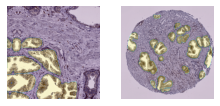

In [34]:
plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0))).numpy().astype(np.uint8)  # H , W , C
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
del ds,dl,imgs,masks

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="coat"><center>Importing CoAT</center></h3>

In [8]:
# sys.path.append('../input/hubmap-coat/')

# from coat import *
# from daformer import *
# from helper import *

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

from einops import rearrange
from functools import partial
from torch import nn, einsum

# __all__ = [
# 	"coat_tiny",
# 	"coat_mini",
# 	"coat_small",
# 	"coat_lite_tiny",
# 	"coat_lite_mini",
# 	"coat_lite_small"
# ]

#---------------------------------------------
#https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py#L15
class LayerNorm2d(nn.Module):
	def __init__(self, dim, eps=1e-6):
		super().__init__()
		self.dim = dim
		self.weight = nn.Parameter(torch.ones(dim))
		self.bias = nn.Parameter(torch.zeros(dim))
		self.eps = eps
	
	def forward(self, x):
		batch_size,C,H,W = x.shape
		#assert C==self.dim, 'C=%d, self.dim=%d'%(C,self.dim)
		#print('C=%d, self.dim=%d'%(C,self.dim))
		
		u = x.mean(1, keepdim=True)
		s = (x - u).pow(2).mean(1, keepdim=True)
		x = (x - u) / torch.sqrt(s + self.eps)
		x = self.weight[:, None, None] * x + self.bias[:, None, None]
		return x
#---------------------------------------------

def _cfg_coat(url='', **kwargs):
	return {
		'url': url,
		'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
		'crop_pct': .9, 'interpolation': 'bicubic',
		'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
		'first_conv': 'patch_embed.proj', 'classifier': 'head',
		**kwargs
	}


class Mlp(nn.Module):
	""" Feed-forward network (FFN, a.k.a. MLP) class. """
	def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
		super().__init__()
		out_features = out_features or in_features
		hidden_features = hidden_features or in_features
		self.fc1 = nn.Linear(in_features, hidden_features)
		self.act = act_layer()
		self.fc2 = nn.Linear(hidden_features, out_features)
		self.drop = nn.Dropout(drop)
	
	def forward(self, x):
		x = self.fc1(x)
		x = self.act(x)
		x = self.drop(x)
		x = self.fc2(x)
		x = self.drop(x)
		return x


class ConvRelPosEnc(nn.Module):
	""" Convolutional relative position encoding. """
	def __init__(self, Ch, h, window):
		"""
		Initialization.
			Ch: Channels per head.
			h: Number of heads.
			window: Window size(s) in convolutional relative positional encoding. It can have two forms:
					1. An integer of window size, which assigns all attention heads with the same window size in ConvRelPosEnc.
					2. A dict mapping window size to #attention head splits (e.g. {window size 1: #attention head split 1, window size 2: #attention head split 2})
					   It will apply different window size to the attention head splits.
		"""
		super().__init__()
		
		if isinstance(window, int):
			window = {window: h}                                                         # Set the same window size for all attention heads.
			self.window = window
		elif isinstance(window, dict):
			self.window = window
		else:
			raise ValueError()
		
		self.conv_list = nn.ModuleList()
		self.head_splits = []
		for cur_window, cur_head_split in window.items():
			dilation = 1                                                                 # Use dilation=1 at default.
			padding_size = (cur_window + (cur_window - 1) * (dilation - 1)) // 2         # Determine padding size. Ref: https://discuss.pytorch.org/t/how-to-keep-the-shape-of-input-and-output-same-when-dilation-conv/14338
			cur_conv = nn.Conv2d(cur_head_split*Ch, cur_head_split*Ch,
			                     kernel_size=(cur_window, cur_window),
			                     padding=(padding_size, padding_size),
			                     dilation=(dilation, dilation),
			                     groups=cur_head_split*Ch,
			                     )
			self.conv_list.append(cur_conv)
			self.head_splits.append(cur_head_split)
		self.channel_splits = [x*Ch for x in self.head_splits]
	
	def forward(self, q, v, size):
		B, h, N, Ch = q.shape
		H, W = size
		assert N == 1 + H * W
		
		# Convolutional relative position encoding.
		q_img = q[:,:,1:,:]                                                              # Shape: [B, h, H*W, Ch].
		v_img = v[:,:,1:,:]                                                              # Shape: [B, h, H*W, Ch].
		
		v_img = rearrange(v_img, 'B h (H W) Ch -> B (h Ch) H W', H=H, W=W)               # Shape: [B, h, H*W, Ch] -> [B, h*Ch, H, W].
		v_img_list = torch.split(v_img, self.channel_splits, dim=1)                      # Split according to channels.
		conv_v_img_list = [conv(x) for conv, x in zip(self.conv_list, v_img_list)]
		conv_v_img = torch.cat(conv_v_img_list, dim=1)
		conv_v_img = rearrange(conv_v_img, 'B (h Ch) H W -> B h (H W) Ch', h=h)          # Shape: [B, h*Ch, H, W] -> [B, h, H*W, Ch].
		
		EV_hat_img = q_img * conv_v_img
		zero = torch.zeros((B, h, 1, Ch), dtype=q.dtype, layout=q.layout, device=q.device)
		EV_hat = torch.cat((zero, EV_hat_img), dim=2)                                # Shape: [B, h, N, Ch].
		
		return EV_hat


class FactorAtt_ConvRelPosEnc(nn.Module):
	""" Factorized attention with convolutional relative position encoding class. """
	def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., shared_crpe=None):
		super().__init__()
		self.num_heads = num_heads
		head_dim = dim // num_heads
		self.scale = qk_scale or head_dim ** -0.5
		
		self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)                                           # Note: attn_drop is actually not used.
		self.proj = nn.Linear(dim, dim)
		self.proj_drop = nn.Dropout(proj_drop)
		
		# Shared convolutional relative position encoding.
		self.crpe = shared_crpe
	
	def forward(self, x, size):
		B, N, C = x.shape
		
		# Generate Q, K, V.
		qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)  # Shape: [3, B, h, N, Ch].
		q, k, v = qkv[0], qkv[1], qkv[2]                                                 # Shape: [B, h, N, Ch].
		
		# Factorized attention.
		k_softmax = k.softmax(dim=2)                                                     # Softmax on dim N.
		k_softmax_T_dot_v = einsum('b h n k, b h n v -> b h k v', k_softmax, v)          # Shape: [B, h, Ch, Ch].
		factor_att        = einsum('b h n k, b h k v -> b h n v', q, k_softmax_T_dot_v)  # Shape: [B, h, N, Ch].
		
		# Convolutional relative position encoding.
		crpe = self.crpe(q, v, size=size)                                                # Shape: [B, h, N, Ch].
		
		# Merge and reshape.
		x = self.scale * factor_att + crpe
		x = x.transpose(1, 2).reshape(B, N, C)                                           # Shape: [B, h, N, Ch] -> [B, N, h, Ch] -> [B, N, C].
		
		# Output projection.
		x = self.proj(x)
		x = self.proj_drop(x)
		
		return x                                                                         # Shape: [B, N, C].


class ConvPosEnc(nn.Module):
	""" Convolutional Position Encoding.
		Note: This module is similar to the conditional position encoding in CPVT.
	"""
	def __init__(self, dim, k=3):
		super(ConvPosEnc, self).__init__()
		self.proj = nn.Conv2d(dim, dim, k, 1, k//2, groups=dim)
	
	def forward(self, x, size):
		B, N, C = x.shape
		H, W = size
		assert N == 1 + H * W
		
		# Extract CLS token and image tokens.
		cls_token, img_tokens = x[:, :1], x[:, 1:]                                       # Shape: [B, 1, C], [B, H*W, C].
		
		# Depthwise convolution.
		feat = img_tokens.transpose(1, 2).view(B, C, H, W)
		x = self.proj(feat) + feat
		x = x.flatten(2).transpose(1, 2)
		
		# Combine with CLS token.
		x = torch.cat((cls_token, x), dim=1)
		
		return x


class SerialBlock(nn.Module):
	""" Serial block class.
		Note: In this implementation, each serial block only contains a conv-attention and a FFN (MLP) module. """
	def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
	             drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
	             shared_cpe=None, shared_crpe=None):
		super().__init__()
		
		# Conv-Attention.
		self.cpe = shared_cpe
		
		self.norm1 = norm_layer(dim)
		self.factoratt_crpe = FactorAtt_ConvRelPosEnc(
			dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpe)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		
		# MLP.
		self.norm2 = norm_layer(dim)
		mlp_hidden_dim = int(dim * mlp_ratio)
		self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
	
	def forward(self, x, size):
		# Conv-Attention.
		x = self.cpe(x, size)                  # Apply convolutional position encoding.
		cur = self.norm1(x)
		cur = self.factoratt_crpe(cur, size)   # Apply factorized attention and convolutional relative position encoding.
		x = x + self.drop_path(cur)
		
		# MLP.
		cur = self.norm2(x)
		cur = self.mlp(cur)
		x = x + self.drop_path(cur)
		
		return x


class ParallelBlock(nn.Module):
	""" Parallel block class. """
	def __init__(self, dims, num_heads, mlp_ratios=[], qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
	             drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
	             shared_cpes=None, shared_crpes=None):
		super().__init__()
		
		# Conv-Attention.
		self.cpes = shared_cpes
		
		self.norm12 = norm_layer(dims[1])
		self.norm13 = norm_layer(dims[2])
		self.norm14 = norm_layer(dims[3])
		self.factoratt_crpe2 = FactorAtt_ConvRelPosEnc(
			dims[1], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[1]
		)
		self.factoratt_crpe3 = FactorAtt_ConvRelPosEnc(
			dims[2], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[2]
		)
		self.factoratt_crpe4 = FactorAtt_ConvRelPosEnc(
			dims[3], num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
			shared_crpe=shared_crpes[3]
		)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		
		# MLP.
		self.norm22 = norm_layer(dims[1])
		self.norm23 = norm_layer(dims[2])
		self.norm24 = norm_layer(dims[3])
		assert dims[1] == dims[2] == dims[3]                              # In parallel block, we assume dimensions are the same and share the linear transformation.
		assert mlp_ratios[1] == mlp_ratios[2] == mlp_ratios[3]
		mlp_hidden_dim = int(dims[1] * mlp_ratios[1])
		self.mlp2 = self.mlp3 = self.mlp4 = Mlp(in_features=dims[1], hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
	
	def upsample(self, x, output_size, size):
		""" Feature map up-sampling. """
		return self.interpolate(x, output_size=output_size, size=size)
	
	def downsample(self, x, output_size, size):
		""" Feature map down-sampling. """
		return self.interpolate(x, output_size=output_size, size=size)
	
	def interpolate(self, x, output_size, size):
		""" Feature map interpolation. """
		B, N, C = x.shape
		H, W = size
		assert N == 1 + H * W
		
		cls_token  = x[:, :1, :]
		img_tokens = x[:, 1:, :]
		
		img_tokens = img_tokens.transpose(1, 2).reshape(B, C, H, W)
		img_tokens = F.interpolate(img_tokens, size=output_size, mode='bilinear')  # FIXME: May have alignment issue.
		img_tokens = img_tokens.reshape(B, C, -1).transpose(1, 2)
		
		out = torch.cat((cls_token, img_tokens), dim=1)
		
		return out
	
	def forward(self, x1, x2, x3, x4, sizes):
		_, (H2, W2), (H3, W3), (H4, W4) = sizes
		
		# Conv-Attention.
		x2 = self.cpes[1](x2, size=(H2, W2))  # Note: x1 is ignored.
		x3 = self.cpes[2](x3, size=(H3, W3))
		x4 = self.cpes[3](x4, size=(H4, W4))
		
		cur2 = self.norm12(x2)
		cur3 = self.norm13(x3)
		cur4 = self.norm14(x4)
		cur2 = self.factoratt_crpe2(cur2, size=(H2,W2))
		cur3 = self.factoratt_crpe3(cur3, size=(H3,W3))
		cur4 = self.factoratt_crpe4(cur4, size=(H4,W4))
		upsample3_2 = self.upsample(cur3, output_size=(H2,W2), size=(H3,W3))
		upsample4_3 = self.upsample(cur4, output_size=(H3,W3), size=(H4,W4))
		upsample4_2 = self.upsample(cur4, output_size=(H2,W2), size=(H4,W4))
		downsample2_3 = self.downsample(cur2, output_size=(H3,W3), size=(H2,W2))
		downsample3_4 = self.downsample(cur3, output_size=(H4,W4), size=(H3,W3))
		downsample2_4 = self.downsample(cur2, output_size=(H4,W4), size=(H2,W2))
		cur2 = cur2  + upsample3_2   + upsample4_2
		cur3 = cur3  + upsample4_3   + downsample2_3
		cur4 = cur4  + downsample3_4 + downsample2_4
		x2 = x2 + self.drop_path(cur2)
		x3 = x3 + self.drop_path(cur3)
		x4 = x4 + self.drop_path(cur4)
		
		# MLP.
		cur2 = self.norm22(x2)
		cur3 = self.norm23(x3)
		cur4 = self.norm24(x4)
		cur2 = self.mlp2(cur2)
		cur3 = self.mlp3(cur3)
		cur4 = self.mlp4(cur4)
		x2 = x2 + self.drop_path(cur2)
		x3 = x3 + self.drop_path(cur3)
		x4 = x4 + self.drop_path(cur4)
		
		return x1, x2, x3, x4


class PatchEmbed(nn.Module):
	""" Image to Patch Embedding """
	def __init__(self, patch_size=16, in_chans=3, embed_dim=768):
		super().__init__()
		patch_size = to_2tuple(patch_size)
		
		self.patch_size = patch_size
		self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
		self.norm = nn.LayerNorm(embed_dim)
	
	def forward(self, x):
		_, _, H, W = x.shape
		out_H, out_W = H // self.patch_size[0], W // self.patch_size[1]
		
		x = self.proj(x).flatten(2).transpose(1, 2)
		out = self.norm(x)
		
		return out, (out_H, out_W)


class CoaT(nn.Module):
	""" CoaT class. """
	def __init__(self, patch_size=16, in_chans=3, embed_dims=[0, 0, 0, 0],
	             serial_depths=[0, 0, 0, 0], parallel_depth=0,
	             num_heads=0, mlp_ratios=[0, 0, 0, 0], qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
	             drop_path_rate=0.,
	             norm_layer=partial(nn.LayerNorm, eps=1e-6),
	             return_interm_layers=True,
	             #out_features=['x1_nocls','x2_nocls','x3_nocls','x4_nocls',],
	             crpe_window={3:2, 5:3, 7:3},
	             pretrain=None,
	             out_norm = nn.Identity, #use nn.Identity, nn.BatchNorm2d, LayerNorm2d
	             **kwargs):
		super().__init__()
		self.return_interm_layers = return_interm_layers
		self.pretrain     = pretrain
		self.embed_dims   = embed_dims
		#self.out_features = out_features
		#self.num_classes  = num_classes
		
		# Patch embeddings.
		self.patch_embed1 = PatchEmbed(patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dims[0])
		self.patch_embed2 = PatchEmbed(patch_size=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
		self.patch_embed3 = PatchEmbed(patch_size=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])
		self.patch_embed4 = PatchEmbed(patch_size=2, in_chans=embed_dims[2], embed_dim=embed_dims[3])
		
		# Class tokens.
		self.cls_token1 = nn.Parameter(torch.zeros(1, 1, embed_dims[0]))
		self.cls_token2 = nn.Parameter(torch.zeros(1, 1, embed_dims[1]))
		self.cls_token3 = nn.Parameter(torch.zeros(1, 1, embed_dims[2]))
		self.cls_token4 = nn.Parameter(torch.zeros(1, 1, embed_dims[3]))
		
		# Convolutional position encodings.
		self.cpe1 = ConvPosEnc(dim=embed_dims[0], k=3)
		self.cpe2 = ConvPosEnc(dim=embed_dims[1], k=3)
		self.cpe3 = ConvPosEnc(dim=embed_dims[2], k=3)
		self.cpe4 = ConvPosEnc(dim=embed_dims[3], k=3)
		
		# Convolutional relative position encodings.
		self.crpe1 = ConvRelPosEnc(Ch=embed_dims[0] // num_heads, h=num_heads, window=crpe_window)
		self.crpe2 = ConvRelPosEnc(Ch=embed_dims[1] // num_heads, h=num_heads, window=crpe_window)
		self.crpe3 = ConvRelPosEnc(Ch=embed_dims[2] // num_heads, h=num_heads, window=crpe_window)
		self.crpe4 = ConvRelPosEnc(Ch=embed_dims[3] // num_heads, h=num_heads, window=crpe_window)
		
		# Enable stochastic depth.
		dpr = drop_path_rate
		
		# Serial blocks 1.
		self.serial_blocks1 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[0], num_heads=num_heads, mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe1, shared_crpe=self.crpe1
			)
			for _ in range(serial_depths[0])]
		)
		
		# Serial blocks 2.
		self.serial_blocks2 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[1], num_heads=num_heads, mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe2, shared_crpe=self.crpe2
			)
			for _ in range(serial_depths[1])]
		)
		
		# Serial blocks 3.
		self.serial_blocks3 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[2], num_heads=num_heads, mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe3, shared_crpe=self.crpe3
			)
			for _ in range(serial_depths[2])]
		)
		
		# Serial blocks 4.
		self.serial_blocks4 = nn.ModuleList([
			SerialBlock(
				dim=embed_dims[3], num_heads=num_heads, mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
				drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
				shared_cpe=self.cpe4, shared_crpe=self.crpe4
			)
			for _ in range(serial_depths[3])]
		)
		
		# Parallel blocks.
		self.parallel_depth = parallel_depth
		if self.parallel_depth > 0:
			self.parallel_blocks = nn.ModuleList([
				ParallelBlock(
					dims=embed_dims, num_heads=num_heads, mlp_ratios=mlp_ratios, qkv_bias=qkv_bias, qk_scale=qk_scale,
					drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr, norm_layer=norm_layer,
					shared_cpes=[self.cpe1, self.cpe2, self.cpe3, self.cpe4],
					shared_crpes=[self.crpe1, self.crpe2, self.crpe3, self.crpe4]
				)
				for _ in range(parallel_depth)]
			)
		
		# Classification head(s).
		# if not self.return_interm_layers:
		# 	self.norm1 = norm_layer(embed_dims[0])
		# 	self.norm2 = norm_layer(embed_dims[1])
		# 	self.norm3 = norm_layer(embed_dims[2])
		# 	self.norm4 = norm_layer(embed_dims[3])
		#
		# 	if self.parallel_depth > 0:                                  # CoaT series: Aggregate features of last three scales for classification.
		# 		assert embed_dims[1] == embed_dims[2] == embed_dims[3]
		# 		self.aggregate = torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=1)
		# 		self.head = nn.Linear(embed_dims[3], num_classes)
		# 	else:
		# 		self.head = nn.Linear(embed_dims[3], num_classes)        # CoaT-Lite series: Use feature of last scale for classification.
		#---
		# add a norm layer for each output
		self.out_norm = nn.ModuleList(
			[ out_norm(embed_dims[i]) for i in range(4)]
		)
		
		# Initialize weights.
		trunc_normal_(self.cls_token1, std=.02)
		trunc_normal_(self.cls_token2, std=.02)
		trunc_normal_(self.cls_token3, std=.02)
		trunc_normal_(self.cls_token4, std=.02)
		self.apply(self._init_weights)
	
	def _init_weights(self, m):
		if isinstance(m, nn.Linear):
			trunc_normal_(m.weight, std=.02)
			if isinstance(m, nn.Linear) and m.bias is not None:
				nn.init.constant_(m.bias, 0)
		elif isinstance(m, nn.LayerNorm):
			nn.init.constant_(m.bias, 0)
			nn.init.constant_(m.weight, 1.0)
	
	@torch.jit.ignore
	def no_weight_decay(self):
		return {'cls_token1', 'cls_token2', 'cls_token3', 'cls_token4'}
	
	# def get_classifier(self):
	# 	return self.head
	
	# def reset_classifier(self, num_classes, global_pool=''):
	# 	self.num_classes = num_classes
	# 	self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
	
	def insert_cls(self, x, cls_token):
		""" Insert CLS token. """
		cls_tokens = cls_token.expand(x.shape[0], -1, -1)
		x = torch.cat((cls_tokens, x), dim=1)
		return x
	
	def remove_cls(self, x):
		""" Remove CLS token. """
		return x[:, 1:, :]
	
	def forward(self, x0):
		B = x0.shape[0]
		
		# Serial blocks 1.
		x1, (H1, W1) = self.patch_embed1(x0)
		cls = self.cls_token1#torch.zeros_like(self.cls_token1)#self.cls_token1
		x1 = self.insert_cls(x1, cls)
		for blk in self.serial_blocks1:
			x1 = blk(x1, size=(H1, W1))
		x1_nocls = self.remove_cls(x1)
		x1_nocls = x1_nocls.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()
		
		# Serial blocks 2.
		x2, (H2, W2) = self.patch_embed2(x1_nocls)
		cls = self.cls_token2# torch.zeros_like(self.cls_token2)#self.cls_token2#
		x2 = self.insert_cls(x2,cls)
		for blk in self.serial_blocks2:
			x2 = blk(x2, size=(H2, W2))
		x2_nocls = self.remove_cls(x2)
		x2_nocls = x2_nocls.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()
		
		# Serial blocks 3.
		x3, (H3, W3) = self.patch_embed3(x2_nocls)
		cls = self.cls_token3#torch.zeros_like(self.cls_token3)# self.cls_token3
		x3 = self.insert_cls(x3, cls)
		for blk in self.serial_blocks3:
			x3 = blk(x3, size=(H3, W3))
		x3_nocls = self.remove_cls(x3)
		x3_nocls = x3_nocls.reshape(B, H3, W3, -1).permute(0, 3, 1, 2).contiguous()
		
		# Serial blocks 4.
		x4, (H4, W4) = self.patch_embed4(x3_nocls)
		cls = self.cls_token4#torch.zeros_like(self.cls_token4)#self.cls_token4
		x4 = self.insert_cls(x4, cls)
		for blk in self.serial_blocks4:
			x4 = blk(x4, size=(H4, W4))
		x4_nocls = self.remove_cls(x4)
		x4_nocls = x4_nocls.reshape(B, H4, W4, -1).permute(0, 3, 1, 2).contiguous()
		
		# Only serial blocks: Early return. ------------------------
		if self.parallel_depth == 0:
			x1_nocls = self.out_norm[0](x1_nocls)
			x2_nocls = self.out_norm[1](x2_nocls)
			x3_nocls = self.out_norm[2](x3_nocls)
			x4_nocls = self.out_norm[3](x4_nocls)
			return [x1_nocls,x2_nocls,x3_nocls,x4_nocls]
		 
	  
		# Parallel blocks. ------------------------------------------
		if self.parallel_depth > 0:
			
			for blk in self.parallel_blocks:
				x1, x2, x3, x4 = blk(x1, x2, x3, x4, sizes=[(H1, W1), (H2, W2), (H3, W3), (H4, W4)])
 
			x1_nocls = self.remove_cls(x1)
			x1_nocls = x1_nocls.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()
			x1_nocls = self.out_norm[0](x1_nocls)
		 
			x2_nocls = self.remove_cls(x2)
			x2_nocls = x2_nocls.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()
			x2_nocls = self.out_norm[1](x2_nocls)
			
			x3_nocls = self.remove_cls(x3)
			x3_nocls = x3_nocls.reshape(B, H3, W3, -1).permute(0, 3, 1, 2).contiguous()
			x3_nocls = self.out_norm[2](x3_nocls)
 
			x4_nocls = self.remove_cls(x4)
			x4_nocls = x4_nocls.reshape(B, H4, W4, -1).permute(0, 3, 1, 2).contiguous()
			x4_nocls = self.out_norm[3](x4_nocls)
			
			return [x1_nocls,x2_nocls,x3_nocls,x4_nocls]
		
		
		# else:
		# 	x2 = self.norm2(x2)
		# 	x3 = self.norm3(x3)
		# 	x4 = self.norm4(x4)
		# 	x2_cls = x2[:, :1]              # Shape: [B, 1, C].
		# 	x3_cls = x3[:, :1]
		# 	x4_cls = x4[:, :1]
		# 	merged_cls = torch.cat((x2_cls, x3_cls, x4_cls), dim=1)       # Shape: [B, 3, C].
		# 	merged_cls = self.aggregate(merged_cls).squeeze(dim=1)        # Shape: [B, C].
		# 	return merged_cls
	
 



#CoaT.
##@register_model
# def coat_tiny(**kwargs):
# 	model = CoaT(patch_size=4, embed_dims=[152, 152, 152, 152], serial_depths=[2, 2, 2, 2], parallel_depth=6, num_heads=8, mlp_ratios=[4, 4, 4, 4], **kwargs)
# 	model.default_cfg = _cfg_coat()
# 	return model
#
# #@register_model
# def coat_mini(**kwargs):
# 	model = CoaT(patch_size=4, embed_dims=[152, 216, 216, 216], serial_depths=[2, 2, 2, 2], parallel_depth=6, num_heads=8, mlp_ratios=[4, 4, 4, 4], **kwargs)
# 	model.default_cfg = _cfg_coat()
# 	return model
#
# #@register_model
# def coat_small(**kwargs):
# 	model = CoaT(patch_size=4, embed_dims=[152, 320, 320, 320], serial_depths=[2, 2, 2, 2], parallel_depth=6, num_heads=8, mlp_ratios=[4, 4, 4, 4], **kwargs)
# 	model.default_cfg = _cfg_coat()
# 	return model
#
# # CoaT-Lite.
# #@register_model
# def coat_lite_tiny(**kwargs):
# 	model = CoaT(patch_size=4, embed_dims=[64, 128, 256, 320], serial_depths=[2, 2, 2, 2], parallel_depth=0, num_heads=8, mlp_ratios=[8, 8, 4, 4], **kwargs)
# 	model.default_cfg = _cfg_coat()
# 	return model
#
# #@register_model
# def coat_lite_mini(**kwargs):
# 	model = CoaT(patch_size=4, embed_dims=[64, 128, 320, 512], serial_depths=[2, 2, 2, 2], parallel_depth=0, num_heads=8, mlp_ratios=[8, 8, 4, 4], **kwargs)
# 	model.default_cfg = _cfg_coat()
# 	return model

#register_model
class coat_lite_small (CoaT):
	def __init__(self, **kwargs):
		super(coat_lite_small, self).__init__(
	        patch_size=4, embed_dims=[64, 128, 320, 512], serial_depths=[3, 4, 6, 3],
			parallel_depth=0, num_heads=8, mlp_ratios=[8, 8, 4, 4], **kwargs)
	 

#register_model
class coat_lite_medium (CoaT):
	def __init__(self, **kwargs):
		super(coat_lite_medium, self).__init__(
			patch_size=4, embed_dims=[128, 256, 320, 512],
			serial_depths=[3, 6, 10, 8],
		    parallel_depth=0, num_heads=8, mlp_ratios=[4, 4, 4, 4],
		    pretrain ='coat_lite_medium_384x384_f9129688.pth',
			**kwargs)

 
class coat_parallel_small (CoaT):
	def __init__(self, **kwargs):
		super(coat_parallel_small, self).__init__(
	        patch_size=4, embed_dims=[152, 320, 320, 320],
			serial_depths=[2, 2, 2, 2],
			parallel_depth=6, num_heads=8, mlp_ratios=[4, 4, 4, 4],
			pretrain ='coat_small_7479cf9b.pth',
			**kwargs)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MixUpSample(nn.Module):
	def __init__( self, scale_factor=2):
		super().__init__()
		assert(scale_factor!=1)
		
		self.mixing = nn.Parameter(torch.tensor(0.5))
		self.scale_factor = scale_factor
	
	def forward(self, x):
		x = self.mixing *F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False) \
			+ (1-self.mixing )*F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
		return x

#https://github.com/lhoyer/DAFormer/blob/master/mmseg/models/decode_heads/daformer_head.py
def Conv2dBnReLU(in_channel, out_channel, kernel_size=3, padding=1,stride=1, dilation=1):
	return nn.Sequential(
		nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, bias=False),
		nn.BatchNorm2d(out_channel),
		nn.ReLU(inplace=True),
	)

class ASPP(nn.Module):
	
	def __init__(self,
				 in_channel,
				 channel,
				 dilation,
				 ):
		super(ASPP, self).__init__()
		
		self.conv = nn.ModuleList()
		for d in dilation:
			self.conv.append(
				Conv2dBnReLU(
					in_channel,
					channel,
					kernel_size=1 if d == 1 else 3,
					dilation=d,
					padding=0 if d == 1 else d,
				)
			)
		
		self.out = Conv2dBnReLU(
			len(dilation) * channel,
			channel,
			kernel_size=3,
			padding=1,
			)
	
	def forward(self, x):
		aspp = []
		for conv in self.conv:
			aspp.append(conv(x))
		aspp = torch.cat(aspp, dim=1)
		out = self.out(aspp)
		return out

#DepthwiseSeparable
class DSConv2d(nn.Module):
	def __init__(self,
				 in_channel,
				 out_channel,
				 kernel_size,
				 stride   = 1,
				 padding  = 0,
				 dilation = 1
		):
		super().__init__()
		
		self.depthwise = nn.Sequential(
			nn.Conv2d( in_channel, in_channel, kernel_size, stride=stride, padding=padding, dilation=dilation),
			nn.BatchNorm2d(in_channel),
			nn.ReLU(inplace=True)
		)
		
		self.pointwise = nn.Sequential(
			nn.Conv2d( in_channel, out_channel, kernel_size=1, stride=1, padding=0),
			nn.BatchNorm2d(out_channel),
			nn.ReLU(inplace=True)
		)
	
	def forward(self, x):
		x = self.depthwise(x)
		x = self.pointwise(x)
		return x

class DSASPP(nn.Module):
	
	def __init__(self,
				 in_channel,
				 channel,
				 dilation,
				 ):
		super(DSASPP, self).__init__()
		
		self.conv = nn.ModuleList()
		for d in dilation:
			if d == 1:
				self.conv.append(
					Conv2dBnReLU(
						in_channel,
						channel,
						kernel_size=1 if d == 1 else 3,
						dilation=d,
						padding=0 if d == 1 else d,
					)
				)
			else:
				self.conv.append(
					DSConv2d(
						in_channel,
						channel,
						kernel_size=3,
						dilation=d,
						padding=d,
					)
				)
		
		self.out = Conv2dBnReLU(
			len(dilation) * channel,
			channel,
			kernel_size=3,
			padding=1,
		)
	 
	def forward(self, x):
		aspp = []
		for conv in self.conv:
			aspp.append(conv(x))
		aspp = torch.cat(aspp, dim=1)
		out = self.out(aspp)
		return out

	
##############################################################################################33

class DaformerDecoder(nn.Module):
	def __init__(
			self,
			encoder_dim = [32, 64, 160, 256],
			decoder_dim = 256,
			dilation = [1, 6, 12, 18],
			use_bn_mlp  = True,
			fuse = 'conv3x3',
	):
		super().__init__()
		self.mlp = nn.ModuleList([
			nn.Sequential(
				# Conv2dBnReLU(dim, decoder_dim, 1, padding=0), #follow mmseg to use conv-bn-relu
				*(
				  ( nn.Conv2d(dim, decoder_dim, 1, padding= 0,  bias=False),
					nn.BatchNorm2d(decoder_dim),
					nn.ReLU(inplace=True),
				)if use_bn_mlp else
				  ( nn.Conv2d(dim, decoder_dim, 1, padding= 0,  bias=True),)
				),
				
				MixUpSample(2**i) if i!=0 else nn.Identity(),
			) for i, dim in enumerate(encoder_dim)])
	  
		if fuse=='conv1x1':
			self.fuse = nn.Sequential(
				nn.Conv2d(len(encoder_dim) * decoder_dim, decoder_dim, 1, padding=0, bias=False),
				nn.BatchNorm2d(decoder_dim),
				nn.ReLU(inplace=True),
			)
		
		if fuse=='conv3x3':
			self.fuse = nn.Sequential(
				nn.Conv2d(len(encoder_dim) * decoder_dim, decoder_dim, 3, padding=1, bias=False),
				nn.BatchNorm2d(decoder_dim),
				nn.ReLU(inplace=True),
			)
		
		if fuse=='aspp':
			self.fuse = ASPP(
				decoder_dim*len(encoder_dim),
				decoder_dim,
				dilation,
			)
			
		if fuse=='ds-aspp':
			self.fuse = DSASPP(
				decoder_dim*len(encoder_dim),
				decoder_dim,
				dilation,
			)
		
	
	def forward(self, feature):
		
		out = []
		for i,f in enumerate(feature):
			f = self.mlp[i](f)
			out.append(f)
			#print(f.shape)
		x = self.fuse(torch.cat(out, dim = 1))
		return x, out


class daformer_conv3x3 (DaformerDecoder):
	def __init__(self, **kwargs):
		super(daformer_conv3x3, self).__init__(
			fuse = 'conv3x3',
			**kwargs
		)
class daformer_conv1x1 (DaformerDecoder):
	def __init__(self, **kwargs):
		super(daformer_conv1x1, self).__init__(
			fuse = 'conv1x1',
			**kwargs
		)

class daformer_aspp (DaformerDecoder):
	def __init__(self, **kwargs):
		super(daformer_aspp, self).__init__(
			fuse = 'aspp',
			**kwargs
		)

In [37]:
import torch
import numpy as np
import tifffile as tiff
from torch import nn

class RGB(nn.Module):
    IMAGE_RGB_MEAN = [0.485, 0.456, 0.406]  # [0.5, 0.5, 0.5]
    IMAGE_RGB_STD = [0.229, 0.224, 0.225]  # [0.5, 0.5, 0.5]

    def __init__(self, ):
        super(RGB, self).__init__()
        self.register_buffer('mean', torch.zeros(1, 3, 1, 1))
        self.register_buffer('std', torch.ones(1, 3, 1, 1))
        self.mean.data = torch.FloatTensor(self.IMAGE_RGB_MEAN).view(self.mean.shape)
        self.std.data = torch.FloatTensor(self.IMAGE_RGB_STD).view(self.std.shape)

    def forward(self, x):
        x = (x - self.mean) / self.std
        return x

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def rle_encode(mask):
	m = mask.T.flatten()
	m = np.concatenate([[0], m, [0]])
	run = np.where(m[1:] != m[:-1])[0] + 1
	run[1::2] -= run[::2]
	rle =  ' '.join(str(r) for r in run)
	return rle

def read_tiff(image_file, mode='rgb'):
	image = tiff.imread(image_file)
	image = image.squeeze()
	if image.shape[0] == 3:
		image = image.transpose(1, 2, 0)
	if mode=='bgr':
		image = image[:,:,::-1]
	image = np.ascontiguousarray(image)
	return image


organ_meta = dotdict(
	kidney = dotdict(
		label = 1,
		um    = 0.5000,
		ftu   ='glomeruli',
	),
	prostate = dotdict(
		label = 2,
		um    = 6.2630,
		ftu   ='glandular acinus',
	),
	largeintestine = dotdict(
		label = 3,
		um    = 0.2290,
		ftu   ='crypt',
	),
	spleen = dotdict(
		label = 4,
		um    = 0.4945,
		ftu   ='white pulp',
	),
	lung = dotdict(
		label = 5,
		um    = 0.7562,
		ftu   ='alveolus',
	),
)

organ_to_label = {k: organ_meta[k].label for k in organ_meta.keys()}
label_to_organ = {v:k for k,v in organ_to_label.items()}

def image_to_tensor(image, mode='rgb'):
    if  mode=='bgr' :
        image = image[:,:,::-1]
    
    x = image.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x)
    return x


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="modify"><center>Modifying CoAT</center></h3>

In [38]:
class Net(nn.Module):
    
    def __init__(self,
                 encoder=coat_parallel_small,
                 decoder=daformer_conv3x3,
                 encoder_cfg={},
                 decoder_cfg={},
                 ):
        
        super(Net, self).__init__()
        decoder_dim = decoder_cfg.get('decoder_dim', 320)

        self.encoder = encoder

        self.rgb = RGB()

        encoder_dim = self.encoder.embed_dims
        # [64, 128, 320, 512]

        self.decoder = decoder(
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
        )
        self.logit = nn.Sequential(
            nn.Conv2d(decoder_dim, 1, kernel_size=1),
            nn.Upsample(scale_factor = 4, mode='bilinear', align_corners=False),
        )

    def forward(self, batch):

        x = self.rgb(batch)

        B, C, H, W = x.shape
        encoder = self.encoder(x)

        last, decoder = self.decoder(encoder)
        logit = self.logit(last)

        output = {}
        probability_from_logit = torch.sigmoid(logit)
        output['probability'] = probability_from_logit

        return output

In [39]:
def init_model():
    encoder = coat_parallel_small()
    checkpoint = '/content/drive/MyDrive/DeepLearning/CoatModel/FOLD0_best_loss.pth'
    #checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
    #state_dict = checkpoint #['model']
    #encoder.load_state_dict(state_dict,strict=False)
    
    net = torch.load(checkpoint)#Net(encoder=encoder).cuda()
    
    return net

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="loss"><center>Loss functions</center></h3>

In [40]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
        self.diceloss = smp.losses.DiceLoss(mode='binary')
        self.binloss = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)

    def forward(self, output, mask):
        dice = self.diceloss(outputs,mask)
        bce = self.binloss(outputs , mask)
        loss = dice * 0.7 + bce * 0.3
        return loss

In [41]:
class DiceCoef(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1.):
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        
        #Round off y_pred
        y_pred = torch.round((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        
        intersection = (y_true * y_pred).sum()
        dice = (2.0*intersection + smooth)/(y_true.sum() + y_pred.sum() + smooth)
        
        return dice

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="add"><center>Additionals</center></h3>

In [42]:
def plot_df(df):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].plot(df['Train_loss'])
    ax[0].plot(df['Val_loss'])
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[1].plot(df['Train_Dice'])
    ax[1].plot(df['Val_Dice'])
    ax[1].legend()
    ax[1].set_title('Dice')

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#c3448b; background:#efe9e9; border:1px dashed #efe50b;" role="tab" aria-controls="training"><center>Training</center></h3>

In [ ]:
print(f"Running on device :  {DEVICE}" )
for fold in range(nfolds):
    
    val_losses = []
    losses = []
    train_scores=[]
    val_scores = []
    best_loss = 999
    best_score = 0
    
    ds_train = HuBMAPDataset(fold=fold, train=True, tfms=transformer())
    ds_val = HuBMAPDataset(fold=fold, train=False)
    
    dataloader_train = torch.utils.data.DataLoader(ds_train,batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
    dataloader_val = torch.utils.data.DataLoader(ds_val,batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
    
    model = init_model().to(DEVICE)
    
    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 5e-4}, 
        {'params': model.encoder.parameters(), 'lr': 8e-4},  
    ])
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(dataloader_train))
    
    loss_func = CustomLoss()
    dice_coe = DiceCoef()
    
    print(f"######## FOLD: {fold} ##############")
    
    for epoch in tqdm.notebook.tqdm(range(EPOCHS)):
        
        ### Train ###########################################################################################
        
        model.train()
        train_loss = 0
        score = 0
        
        for data in tqdm.notebook.tqdm(dataloader_train ,total = len(dataloader_train)):
            optimizer.zero_grad()
            img, mask = data
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
        
            outputs = model(img)['probability']    

            loss = loss_func(outputs, mask)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            score += dice_coe(outputs,mask).item()
            
        train_loss /= len(dataloader_train)
        score /= len(dataloader_train)
        losses.append(train_loss)
        train_scores.append(score)
        print(f"FOLD: {fold}, EPOCH: {epoch + 1}, train_loss: {train_loss} , Dice coe : {score} ") #
        
        
        gc.collect()
        torch.cuda.empty_cache()
        
        ### Validation ####################################################################################
        
        model.eval()
        
        with torch.no_grad():
            
            valid_loss = 0
            val_score = 0
            
            for data in dataloader_val:
                
                img, mask = data
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)

                outputs = model(img)['probability']

                loss = loss_func(outputs, mask)
                valid_loss += loss.item()
                val_score += dice_coe(outputs,mask).item()
                
            valid_loss /= len(dataloader_val)
            val_losses.append(valid_loss)
            
            val_score /= len(dataloader_val)
            val_scores.append(val_score)
            
            print(f"FOLD: {fold}, EPOCH: {epoch + 1}, valid_loss: {valid_loss} , Val Dice COE : {val_score}") #
            
            gc.collect()
            torch.cuda.empty_cache()
            
        if val_score > best_score:
            best_score = val_score
            torch.save(model.state_dict(), f"/content/drive/MyDrive/DeepLearning/CoatModel/{fold}_best_score.pth")
            print(f"Saved model for best score : FOLD{fold}_best_score.pth")
            
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model, f"/content/drive/MyDrive/DeepLearning/CoatModel/FOLD{fold}_best_loss.pth")
            print(f"Saved model for best loss : FOLD{fold}_best_loss.pth")   
           
    break
    
    column_names = ['Train_loss','Val_loss','Train_Dice','Val_Dice']
    df = pd.DataFrame(np.stack([losses,val_losses,train_scores,val_scores],axis=1),columns=column_names)
    print(f" ################# FOLD {fold} #####################")
    plot_df(df)
    plt.show(block=False)
    df.to_csv(f"logs_fold{fold}.csv")

Running on device :  cuda
######## FOLD: 0 ##############


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
